# Search Algorithms

:label:`course_alg`


## AutoGluon System Implementatin Logic

![](https://raw.githubusercontent.com/zhanghang1989/AutoGluonWebdata/master/doc/api/autogluon_system.png)

AutoGluon system includes Searcher, Scheduler and Resource Manager:

- The Searcher suggests configurations for the next training jobs.
- Scheduler schedule the training job when the computation resources are available.

In this tutorial, we will illustrate how the search algorithm works and
compare the performance on a toy experiments.

## FIFO Scheduling vs. Early Stopping

In this section, we will compare the different behaviors of a sequential FIFO scheduling
using :class:`autogluon.scheduler.FIFOScheduler` vs a preemptive scheduling algorithm
:class:`autogluon.scheduler.HyperbandScheduler` which terminates the trial with bad
configurations at the early/middle stages.

### Create A Dummy Training Function

In [1]:
import numpy as np
import autogluon as ag

@ag.args(
    lr=ag.space.Real(1e-3, 1e-2, log=True),
    wd=ag.space.Real(1e-3, 1e-2))
def train_fn(args, reporter):
    for e in range(10):
        dummy_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e, accuracy=dummy_accuracy, lr=args.lr, wd=args.wd)

### First In First Out  Scheduler
This scheduler runs training trials in order

In [2]:
scheduler = ag.scheduler.FIFOScheduler(train_fn,
                                       resource={'num_cpus': 2, 'num_gpus': 0},
                                       num_trials=20,
                                       reward_attr='accuracy',
                                       time_attr='epoch')
scheduler.run()
scheduler.join_jobs()


Visualize the results:

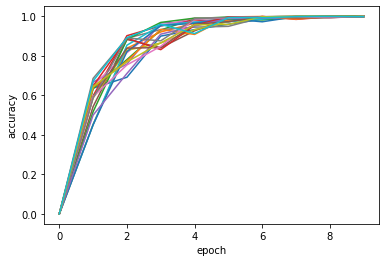

In [3]:
scheduler.get_training_curves(plot=True, use_legend=False)

### Hyperband Scheduler
Early-terminates training trials which do not appear promising during the early stages to free compute resources for more promising hyperparameter-configurations

In [4]:
scheduler = ag.scheduler.HyperbandScheduler(train_fn,
                                            resource={'num_cpus': 2, 'num_gpus': 0},
                                            num_trials=20,
                                            reward_attr='accuracy',
                                            time_attr='epoch',
                                            grace_period=1)
scheduler.run()
scheduler.join_jobs()


Visualize the results:

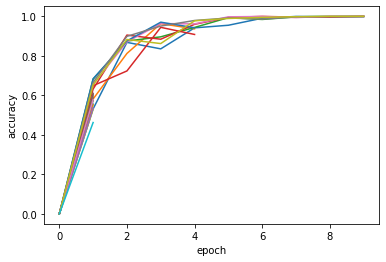

In [5]:
scheduler.get_training_curves(plot=True, use_legend=False)

## Random Search vs. Reinforcement Learning

In this section, we will demonstate the behaviors of random search and reinforcement learning
in a simple simulation environment.

### Create A Reward Function for Toy Experiments

Import the packages:

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Input Space `x = [0: 99], y = [0: 99]`.
The rewards is a combination of 2 gaussians as shown in the following figure:

Generate the simulated reward as a mixture of 2 gaussians:

In [7]:
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A): 
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2) 

x, y = np.linspace(0, 99, 100), np.linspace(0, 99, 100) 
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape) 
ps = [(20, 70, 35, 40, 1),
      (80, 40, 20, 20, 0.7)]
for p in ps:
    Z += gaussian2d(X, Y, *p)

Visualize the reward space:

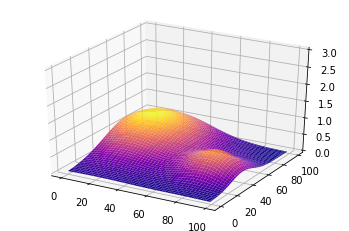

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, cmap='plasma') 
ax.set_zlim(0,np.max(Z)+2)
plt.show()

### Create Training Function

We can simply define an AutoGluon searchable function with a decorator `ag.args`.
The `reporter` is used to communicate with AutoGluon search and scheduling algorithms.

In [9]:
@ag.args(
    x=ag.space.Categorical(*list(range(100))),
    y=ag.space.Categorical(*list(range(100))),
)
def rl_simulation(args, reporter):
    x, y = args.x, args.y
    reporter(accuracy=Z[y][x])

### Random Search

In [10]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=300,
                                              reward_attr="accuracy",
                                              resume=False)
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))



Best config: {'x.choice': 17, 'y.choice': 67}, best reward: 0.987117384407588


### Reinforcement Learning

In [11]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=300,
                                        reward_attr="accuracy",
                                        controller_batch_size=4,
                                        controller_lr=5e-3)
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))


Best config: {'x.choice': 21, 'y.choice': 74}, best reward: 0.9892484241569526


### Compare the performance

Get the result history:

In [12]:
results_rl = [v[0]['accuracy'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['accuracy'] for v in random_scheduler.training_history.values()]

Average result every 10 trials:

In [13]:
import statistics
results1 = [statistics.mean(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [statistics.mean(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

Plot the results:

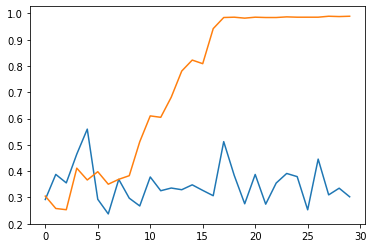

In [14]:
plt.plot(range(len(results1)), results1, range(len(results2)), results2)

Exit AutoGluon:

In [15]:
ag.done()